Data cleaning

In [1]:
#UDF for get data


In [30]:
import pandas as pd

raw_data=pd.read_csv('https://data.cityofnewyork.us/resource/uip8-fykc.csv?$limit=200000')
new_data=raw_data.dropna(how='any')
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154011 entries, 0 to 155506
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   arrest_key         154011 non-null  int64  
 1   arrest_date        154011 non-null  object 
 2   pd_cd              154011 non-null  float64
 3   pd_desc            154011 non-null  object 
 4   ky_cd              154011 non-null  float64
 5   ofns_desc          154011 non-null  object 
 6   law_code           154011 non-null  object 
 7   law_cat_cd         154011 non-null  object 
 8   arrest_boro        154011 non-null  object 
 9   arrest_precinct    154011 non-null  int64  
 10  jurisdiction_code  154011 non-null  int64  
 11  age_group          154011 non-null  object 
 12  perp_sex           154011 non-null  object 
 13  perp_race          154011 non-null  object 
 14  x_coord_cd         154011 non-null  int64  
 15  y_coord_cd         154011 non-null  int64  
 16  la

In [31]:
new_data.head(5)

,arrest_key,arrest_date,pd_cd,pd_desc,ky_cd,ofns_desc,law_code,law_cat_cd,arrest_boro,arrest_precinct,jurisdiction_code,age_group,perp_sex,perp_race,x_coord_cd,y_coord_cd,latitude,longitude,geocoded_column
0,238013474,2021-12-18T00:00:00.000,157.0,RAPE 1,104.0,RAPE,PL 1303501,F,Q,105,97,18-24,M,BLACK,1057636,203954,40.726187,-73.735234,POINT (-73.73523390399998 40.72618713000002)
1,236943583,2021-11-25T00:00:00.000,263.0,"ARSON 2,3,4",114.0,ARSON,PL 1501500,F,K,69,71,25-44,M,BLACK,1014340,171320,40.636868,-73.891586,POINT (-73.89158591899997 40.63686750900007)
2,234938876,2021-10-14T00:00:00.000,594.0,OBSCENITY 1,116.0,SEX CRIMES,PL 2631100,F,K,61,0,25-44,M,WHITE,995244,155739,40.594145,-73.960415,POINT (-73.96041495199995 40.59414516900005)
3,234788259,2021-10-11T00:00:00.000,263.0,"ARSON 2,3,4",114.0,ARSON,PL 1501001,F,B,42,71,18-24,M,BLACK,1009058,239616,40.824340,-73.910365,POINT (-73.91036538099996 40.82433953100008)
5,234117071,2021-09-27T00:00:00.000,157.0,RAPE 1,104.0,RAPE,PL 1303501,F,K,84,0,25-44,M,BLACK,989013,192652,40.695469,-73.982825,POINT (-73.98282507899995 40.69546894100006)


In [17]:
for feat in new_data.columns[:-1]:
    if new_data[feat].dtype == object:
        print(feat)

arrest_date
pd_desc
ofns_desc
law_code
law_cat_cd
arrest_boro
age_group
perp_sex
perp_race


Data exploratory analysis

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

Database

In [6]:
import sqlite3

In [7]:
con = sqlite3.connect('nypd_data.db')

In [ ]:
new_data.to_sql(name='data_a',con=con)

Search engine=>dashboard

In [8]:
#import geopandas as gpd
#from ipyleaflet import Map,basemaps,Marker,Heatmap
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
from keplergl import KeplerGl
import requests
import json

In [9]:
def get_loc():
    ip_request = requests.get('https://get.geojs.io/v1/ip.json')
    my_ip = ip_request.json()['ip']
    geo_request = requests.get('https://get.geojs.io/v1/ip/geo/' +my_ip + '.json')
    geo_data = geo_request.json()
    my_la= float(geo_data['latitude'])
    my_lo = float(geo_data['longitude'])
    loc={'latitude':my_la,
         'longitude':my_lo
    }
    my_loc=pd.DataFrame(loc,index=[0])
    return(my_loc)



my_loc=get_loc()
map_1 = KeplerGl(height=400)
map_1.add_data(data=my_loc)


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


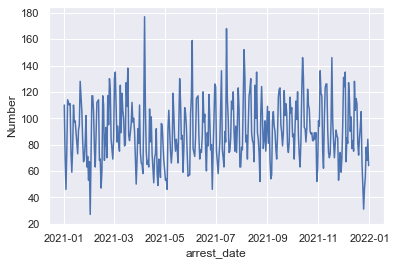

In [40]:
#Initialize a grid layout
sns.set(style="darkgrid")
arrest_date=pd.read_sql("SELECT arrest_date, count(arrest_date) as 'Number' FROM data_a GROUP BY arrest_date",con=con)
arrest_date['arrest_date'] = pd.to_datetime(arrest_date['arrest_date'],format='%Y/%m/%d')
#plt.figure(figsize = (18,12))
g=sns.lineplot(x='arrest_date',y='Number',data=arrest_date)
#plt.show()


In [49]:

ALL='ALL'
def unique_val(arr):
    unique=arr.unique().tolist()
    unique.sort()
    unique.insert(0,ALL)
    return unique

drop_boro=widgets.Dropdown(
    options= unique_val(new_data.arrest_boro),
    value=ALL,
    description='select boro'
)

def draw_boro_date(change):
    #BKMQS
    if change==ALL:
        data=pd.read_sql("SELECT arrest_date, count(arrest_date) FROM data_a GROUP BY arrest_date",con=con)
    elif change=='B':
        data=pd.read_sql("SELECT arrest_date, count(arrest_date) FROM data_a where arrest_boro=='B' GROUP BY arrest_date",con=con)
    elif change=='K':
        data=pd.read_sql("SELECT arrest_date, count(arrest_date) FROM data_a where arrest_boro=='K' GROUP BY arrest_date",con=con)
    elif change=='M':
        data=pd.read_sql("SELECT arrest_date, count(arrest_date) FROM data_a where arrest_boro=='M' GROUP BY arrest_date",con=con)
    elif change=='Q':
        data=pd.read_sql("SELECT arrest_date, count(arrest_date) FROM data_a where arrest_boro=='Q' GROUP BY arrest_date",con=con)
    elif change=='S':
        data=pd.read_sql("SELECT arrest_date, count(arrest_date) FROM data_a where arrest_boro=='S' GROUP BY arrest_date",con=con)
    data['arrest_date'] = pd.to_datetime(data['arrest_date'],format='%Y/%m/%d')
    return data

def draw_boro_ofns(change):
    if change==ALL:
        data=pd.read_sql("SELECT ofns_desc, count(ofns_desc) FROM data_a GROUP BY ofns_desc",con=con)
    elif change=='B':
        data=pd.read_sql("SELECT ofns_desc, count(ofns_desc) FROM data_a where arrest_boro=='B' GROUP BY ofns_desc",con=con)
    elif change=='K':
        data=pd.read_sql("SELECT ofns_desc, count(ofns_desc) FROM data_a where arrest_boro=='K' GROUP BY ofns_desc",con=con)
    elif change=='M':
        data=pd.read_sql("SELECT ofns_desc, count(ofns_desc) FROM data_a where arrest_boro=='M' GROUP BY ofns_desc",con=con)
    elif change=='Q':
        data=pd.read_sql("SELECT ofns_desc, count(ofns_desc) FROM data_a where arrest_boro=='Q' GROUP BY ofns_desc",con=con)
    elif change=='S':
        data=pd.read_sql("SELECT ofns_desc, count(ofns_desc) FROM data_a where arrest_boro=='S' GROUP BY ofns_desc",con=con)
    #data['ofns_desc'] = pd.to_datetime(data['arrest_date'],format='%Y/%m/%d')
    return data
    



def draw_boro_time(change):
    fig, axes = plt.subplots(1, 2,figsize=(15, 5))

    boro_time=sns.lineplot(ax=axes[0],x='arrest_date',y='count(arrest_date)',data= draw_boro_date(change))

    
    #arrest_num=pd.read_sql('SELECT arrest_boro, count(arrest_boro) FROM data_a GROUP BY arrest_boro',con=con)
    boro_num=sns.barplot(ax=axes[1],x='ofns_desc',y='count(ofns_desc)',data=draw_boro_ofns(change))
'''
grid = widgets.GridspecLayout(5,3, height='900px')

grid[0,0]=drop_boro
grid[1,:]=draw_boro_time(drop_boro)
display(grid)
'''
interact(draw_boro_time,change=drop_boro)


interactive(children=(Dropdown(description='select boro', options=('ALL', 'B', 'K', 'M', 'Q', 'S'), value='ALL…

<function __main__.draw_boro_time(change)>

Map

In [ ]:
map_data=new_data[['latitude','longitude']]
print(map_data)
map_2 = KeplerGl(height=600)  
map_2.add_data(data=map_data.head(100))  

         latitude  longitude
0       40.726187 -73.735234
1       40.636868 -73.891586
2       40.594145 -73.960415
3       40.824340 -73.910365
5       40.695469 -73.982825
...           ...        ...
155502  40.846260 -73.901755
155503  40.663302 -73.925425
155504  40.623227 -74.149227
155505  40.684194 -73.916085
155506  40.690226 -73.829932

[154011 rows x 2 columns]
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
